## 📘 What Does “Document” Mean in LangChain?

In LangChain (and similar frameworks like LlamaIndex), the term **“Document”** refers to a small data structure that contains **text content** and its associated **metadata**.

When using a loader like `PyPDFLoader`, each **page** or **chunk** of a PDF is converted into a separate `Document` object.

---

### 🧩 Structure of a Document

A `Document` object has two main parts:

| Attribute | Description |
|------------|--------------|
| **`page_content`** | The actual text extracted from a file (for example, one page or section). |
| **`metadata`** | A dictionary containing details about the text source — such as filename, page number, and file type. |

Example representation:

```python
Document(
    page_content="This is the text extracted from page 1 of the PDF...",
    metadata={
        "source": "report.pdf",
        "page": 1,
        "file_type": "pdf"
    }
)
```
### 🧠 Why It Matters

Using `Document` objects instead of raw text makes it easier to:
- Track **where** each piece of text came from.
- Store **context** (like page number or file name).
- Prepare the data for **search**, **embedding**, or **summarization** tasks.

---

### ✅ Summary

> A **Document** is a container that holds:
> - The **text content** extracted from a data source (like a PDF page).
> - **Metadata** describing that content’s origin and properties.



# Chuncking

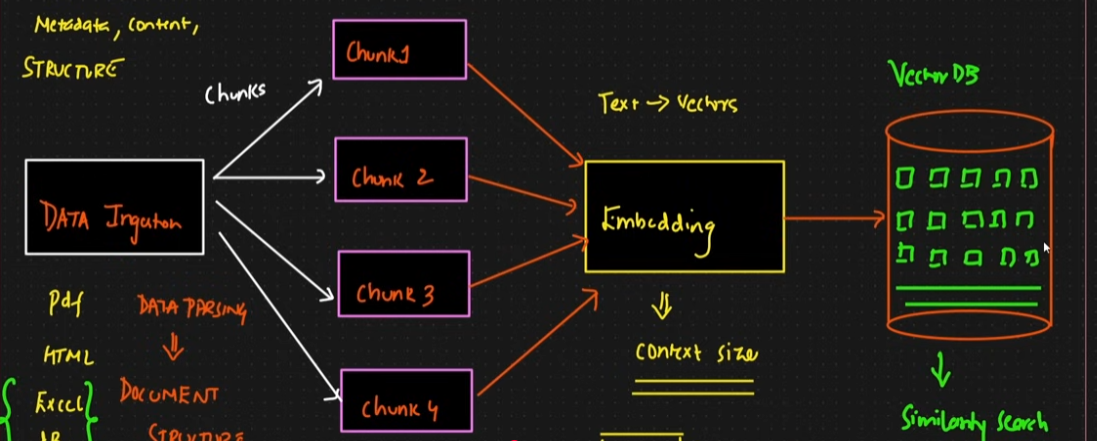

In [60]:
import os
from langchain_community.document_loaders import PyPDFLoader, PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pathlib import Path

In [88]:
### Read PDF
def processPdfs(pdf_directory):
    # Create an empty list to store all document objects from all PDFs
    all_docs = []

    # Convert the directory path (string) into a Path object for easy file handling
    pdf_dir = Path(pdf_directory)

    # Find all PDF files in this directory (including subfolders)
    pdf_files = list(pdf_dir.glob('**/*.pdf'))

    # Print how many PDF files were found
    print(f'Found {len(pdf_files)} pdf files to process')

    print(pdf_files)
    print(str(pdf_files[0]))
    # Loop through each found PDF file
    for pdf_file in pdf_files:
        try:
            # Create a PDF loader (from LangChain or similar library)
            # Convert Path object to string since the loader expects a string path
            loader = PyPDFLoader(str(pdf_file))

            # Load the PDF into a list of document objects
            documents = loader.load()

            # Add extra metadata to each document for tracking
            for doc in documents:
                # Save the source filename (without the full path)
                doc.metadata['source_file'] = pdf_file.name

                # Add file type for clarity (useful if later you handle other file formats)
                doc.metadata['file_type'] = 'pdf'

            # Add all documents from this PDF to the main list
            all_docs.extend(documents)

        except Exception as e:
            # Print any error that happens while loading a file
            print(e)

    # Return the list of all loaded and processed documents
    return all_docs


In [62]:
'''
🧩 Step-by-step explanation

RecursiveCharacterTextSplitter works recursively, meaning:

It tries to split text using the first separator in the list.

If a resulting piece is still longer than chunk_size,
it tries the next separator in the list to break it further.

This continues through all separators (["\n\n", "\n", " ", ""])
until every chunk is within the allowed chunk_size.
'''
def split_document(documents,chunk_size=1000,chunk_overlap=200):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n","\n", " ", ""]
    )
    split_docs=text_splitter.split_documents(documents)
    print(f'Split {len(documents)} documents into {len(split_docs)} chunks')
    
    if split_docs:
        print(f'\nExample Chunk')
        print(f'Content: {split_docs[0].page_content[:200]}...')
        print('\n\nMetadata: ')
        print(f'Metadata of chunk 0 {split_docs[0].metadata}')
        print('\n\n')
        print(f'Metadata of chunk 1 {split_docs[1].metadata}')
    return split_docs

# Embedding Class

## Transform Chunks into Embedding
- to be stored in vectorDB

In [63]:
import numpy as np
from sentence_transformers import SentenceTransformer

import chromadb
from chromadb.config import Settings
import uuid
from typing import List,Dict,Any,Tuple
from sklearn.metrics.pairwise import cosine_similarity

In [64]:
class EmbeddingManager:
    def __init__(self, model_name="all-miniLM-L6-V2"):
        self.model_name=model_name
        self.model=None
        self._load_model()
    def _load_model(self):
        try:
            print(f'Loading embedding model: {self.model_name}')
            self.model = SentenceTransformer(self.model_name)
            print(f'Model loadded successfully. Embedding dimension: {self.model.get_sentence_embedding_dimension()}')
        except Exception as e:
            print(f'Error {e}')  
    
    
    
    def generate_embedding(self,texts: list[str])->np.ndarray:
        '''
        Args:
            texts: list of text strings to embed
        returns:
            numpy array of embeddings with shape (len(texts), embedding_dimension)
        '''
        if not self.model:
            raise ValueError("Model not loaded")
        print(f'Generating embedding for {len(texts)} texts .....')
        embeddings = self.model.encode(texts, show_progress_bar=True)
        print(f'generated embeddings with shape {embeddings.shape}')
        return embeddings

    def get_embedding_dimension(self):
        if not self.model:
            raise ValueError("Model not loadded")
        return self.model.get_sentence_embedding_dimension()

# VecctorDB Class

In [65]:
### vector store
class VectorStore:
    def __init__(self,collection_name="pdf_documents", persist_directory = "../data/vector_store"):
        '''
        Args:
            colletion_name: Name of the chromadb collection
            presist_directory: Directory to presist the vector store
        '''
        self.collection_name = collection_name
        self.persist_directory = persist_directory
        self.client=None
        self.collection=None
        self.initialize_store()

    def initialize_store(self):
        try:
            '''Initilaize chromaDB client and collection'''
            os.makedirs(self.persist_directory,exist_ok=True)
            self.client = chromadb.PersistentClient(path=self.persist_directory)
    
            # get or create collection
            self.collection = self.client.get_or_create_collection(
                name=self.collection_name,
                metadata={"description": "PDF document embeddings for RAG"}
            )
    
            print(f'Vector Store initilized. Collection: {self.collection_name}')
            print(f"Existing documents in collection: {self.collection.count()}")
        except Exception as e:
            print(e)

    def add_document(self,documents: List[Any],embeddings: np.ndarray):
        """
            add documents and their embeddings to the vector store
            args:
                documents: list of langChain documents
                embeddings: Corresponding embeddings for the documents
        """
        if len(documents) != len(embeddings):
            raise ValueError("Number of documents must match number of embeddings")
        print(f"adding {len(documents)} documents to vector store....")

        ids=[]
        metadatas=[]
        documents_text=[]
        embeddings_list=[]

        for i, (doc,embedding) in enumerate(zip(documents,embeddings)):
            doc_id = f"doc_{uuid.uuid4().hex[:8]}_{i}"
            ids.append(doc_id)

            metadata = dict(doc.metadata)
            metadata['doc_index']=i
            metadata['content_length'] = len(doc.page_content)
            metadatas.append(metadata)

            documents_text.append(doc.page_content)

            embeddings_list.append(embedding.tolist())
        try:
            self.collection.add(
                ids=ids,
                embeddings=embeddings_list,
                metadatas=metadatas,
                documents=documents_text
            )
            print(f"Successfully added {len(documents)} documents to vector store")
            print(f"Total documents in collection: {self.collection.count()}")
        except Exception as e:
            print(e)
        

# Rag Class

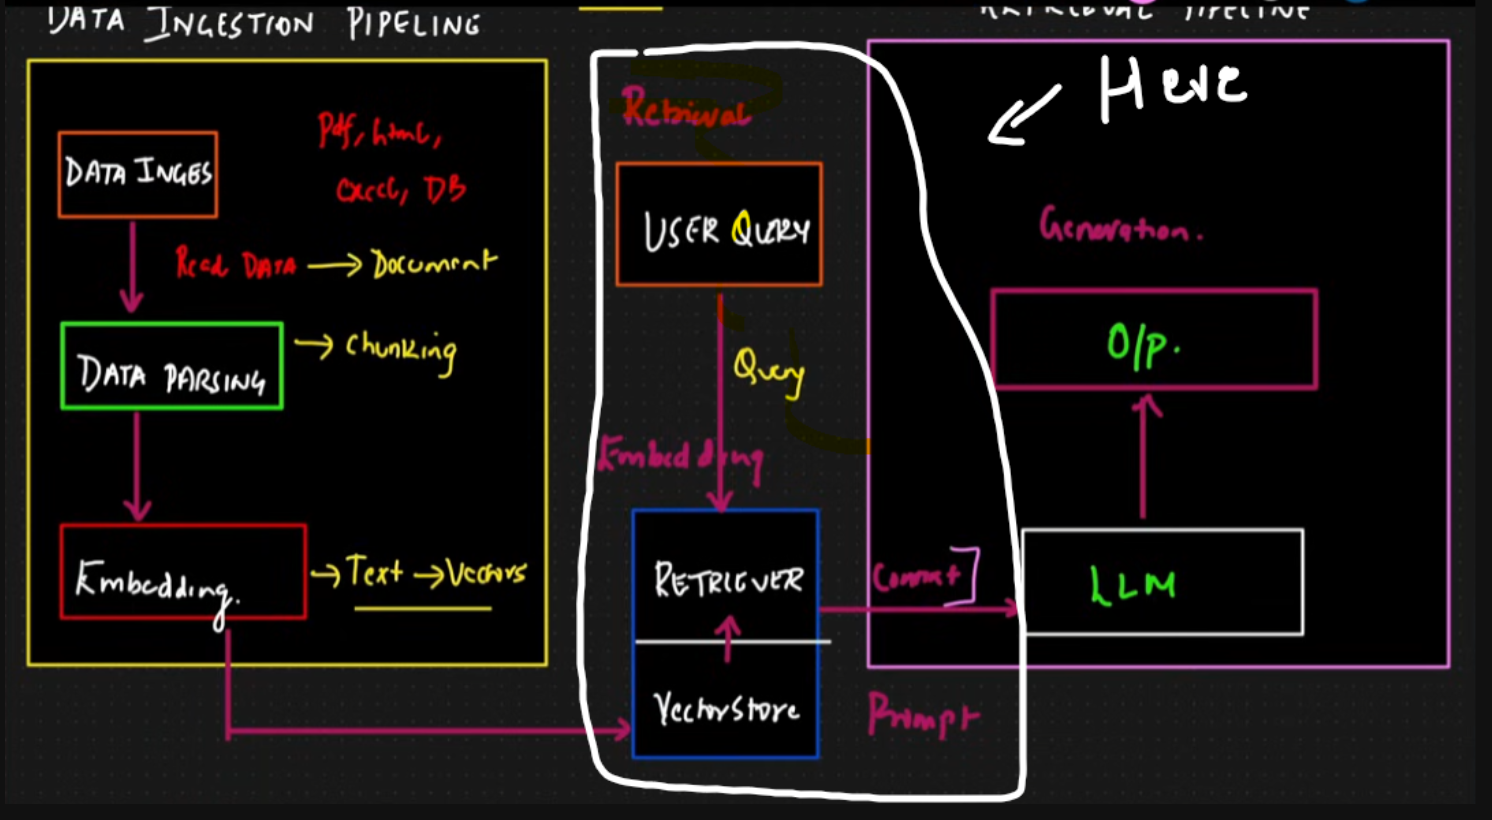

In [66]:
class RAGRetriever:
    def __init__(self,vector_store, emb_manager):
        self.vector_store=vector_store
        self.emb_manager=emb_manager

    def retrieve(self,query: str, top_k: int =5,score_threshold: float=0.0) -> List[Dict[str,Any]]:
        """
        Args:
            query: The search query
            top_k: number of top results to return
            score_threshold: minimum similarity score threshold

        return:
            list of dict containing retrieved documents and metadata
        """
        print(f"retrieving documents for query: {query}")
        print(f"Top l: {top_k}, Score threshold: {score_threshold}")

        query_embedding = self.emb_manager.generate_embedding([query])[0]

        try:
            results=self.vector_store.collection.query(
                query_embeddings=[query_embedding.tolist()],
                n_results=top_k
            )

            retrieved_docs=[]
            if results['documents'] and results['documents'][0]:
                documents = results['documents'][0]
                metadatas = results['metadatas'][0]
                distances = results['distances'][0]
                ids=results['ids'][0]

                for i,(doc_id,document,metadata,distance) in enumerate(zip(ids,documents,metadatas,distances)):
                    similaruty_score=1-distance
                    if similaruty_score >= score_threshold:
                        retrieved_docs.append({
                            "id":doc_id,
                            "content": document,
                            "metadata":metadata,
                            "similarity_score": similaruty_score,
                            "distance": distance,
                            "rank": i+1
                        })
                print(f"Retrieved {len(retrieved_docs)} documents after filtering")
            else:
                print("No documents found")

            return retrieved_docs
        except Exception as e:
            print(e)
            return []

    

# Embedding text + Storing in DB

In [67]:
all_pdf_docs = processPdfs('../data/pdf_files')
chunks = split_document(all_pdf_docs)

Found 1 pdf files to process
[WindowsPath('../data/pdf_files/Chapter4p1(2).pdf')]
..\data\pdf_files\Chapter4p1(2).pdf
Split 25 documents into 25 chunks

Example Chunk
Content: MATH314
Advanced Discrete 
Mathematics...


Metadata: 
Metadata of chunk 0 {'producer': 'Microsoft® PowerPoint® 2016', 'creator': 'Microsoft® PowerPoint® 2016', 'creationdate': '2025-08-28T14:42:13+03:00', 'title': 'The Foundations: Logic and Proofs', 'author': 'Richard Scherl', 'moddate': '2025-08-28T14:42:13+03:00', 'source': '..\\data\\pdf_files\\Chapter4p1(2).pdf', 'total_pages': 25, 'page': 0, 'page_label': '1', 'source_file': 'Chapter4p1(2).pdf', 'file_type': 'pdf'}



Metadata of chunk 1 {'producer': 'Microsoft® PowerPoint® 2016', 'creator': 'Microsoft® PowerPoint® 2016', 'creationdate': '2025-08-28T14:42:13+03:00', 'title': 'The Foundations: Logic and Proofs', 'author': 'Richard Scherl', 'moddate': '2025-08-28T14:42:13+03:00', 'source': '..\\data\\pdf_files\\Chapter4p1(2).pdf', 'total_pages': 25, 'page': 

In [68]:
emb_manager = EmbeddingManager()
vector_store=VectorStore()

Loading embedding model: all-miniLM-L6-V2
Model loadded successfully. Embedding dimension: 384
Vector Store initilized. Collection: pdf_documents
Existing documents in collection: 496


In [69]:
texts=[doc.page_content for doc in chunks] ## extract texts and leave metadata
texts_embeddings = emb_manager.generate_embedding(texts)

Generating embedding for 25 texts .....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

generated embeddings with shape (25, 384)


In [70]:
print(texts_embeddings[0][:30], texts_embeddings[0].shape)

[-0.00749783  0.03079361 -0.05607671 -0.03558831 -0.10494205  0.00795708
  0.10590161  0.01665626 -0.04217895  0.03738221 -0.07477876 -0.06621483
  0.00088901  0.06882013 -0.00988392  0.09829976  0.00017693  0.014441
 -0.00909093 -0.08571137 -0.0789847  -0.12316952  0.00422777  0.06434672
  0.05077395  0.05222658  0.04675472 -0.01705355  0.1166212  -0.07207605] (384,)


In [71]:
## store in vectorDB
vector_store.add_document(chunks,texts_embeddings)

adding 25 documents to vector store....
Successfully added 25 documents to vector store
Total documents in collection: 521


In [72]:
reteriver = RAGRetriever(vector_store, emb_manager)

# LLM

In [89]:
os.environ["GROQ_API_KEY"] = 'add your api key'

In [74]:
import os
from groq import Groq

llm = Groq() 
MODEL_NAME = "llama-3.1-8b-instant"

# chat_completion = client.chat.completions.create(
#     messages=[
#         {
#             "role": "user",
#             "content": "Who is the king of Saudi arabia",
#         }
#     ],
#     model=MODEL_NAME,
# )

# # Print the model's response
# print(f"Model: {MODEL_NAME}")
# print("--- Response ---")
# print(chat_completion.choices[0].message.content)

In [75]:
def rag_simple(query,retriever,llm,top_k=3):
    ## retriever the context
    results=retriever.retrieve(query,top_k=top_k)
    print(f'Length of result {len(results)}')
    context="\n\n".join([doc['content'] for doc in results]) if results else ""
    if not context:
        return "No relevant context found to answer the question."

    augmented_prompt = f"""
    You are an expert Q&A system. Use the following context to answer the question. 
    If you cannot find the answer in the provided context, state that you cannot answer based on the given information.

    --- CONTEXT ---
    {context}
    
    --- QUESTION ---
    {query}
    """
    
    ## generate the answer
    response = llm.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": augmented_prompt,
        }
    ],
    model=MODEL_NAME,
)
    
    
    return response.choices[0].message.content

In [87]:
answer=rag_simple("math314 talk about it",reteriver,llm)
print('\n\n\n\n\n\n'+answer)

retrieving documents for query: math314 talk about it
Top l: 3, Score threshold: 0.0
Generating embedding for 1 texts .....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

generated embeddings with shape (1, 384)
Retrieved 2 documents after filtering
Length of result 2






MATH314:  Advanced Discrete Mathematics. 

It seems you are looking for a general discussion on the topic. Advanced Discrete Mathematics, also known as MATH314, is a complex and abstract branch of mathematics dealing with discrete elements rather than continuous functions like in calculus. 

Advanced Discrete Mathematics can involve various topics such as: 
- Boolean algebra, 
- Graph theory, 
- Number theory, 
- Combinatorics, 
- Combinatorial design theory, 
- Discrete optimization, 
- and computational complexity theory.



However, the provided information does not specify what you would like to talk about, so if you have a question about this topic, please be more specific, so I can attempt a more suitable answer.
